![Population Modelling](https://www.ornl.gov/sites/default/files/news/images/ornlmodelexp.jpg)

### Population Modelling

This is a cursory notebook establishing basic time series processes on US Population data. I'll be making forecasts into future years starting from 2018, until 2024. Note, this notebook is written as of December 15th, 2023.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For Time Series Modelling
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Data/uspopulation.csv', index_col = 'DATE', parse_dates = True)

In [3]:
# Because we know the data has a monthly start frequency
df.index.freq = 'MS'

In [7]:
df.describe()

,PopEst
count,96.000000
mean,319826.760417
std,5159.523729
min,311037.000000
25%,315419.000000
50%,319919.500000
75%,324395.250000
max,328393.000000


In [68]:
df

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699
...,...
2018-08-01,327698
2018-09-01,327893
2018-10-01,328077


<Axes: xlabel='DATE'>

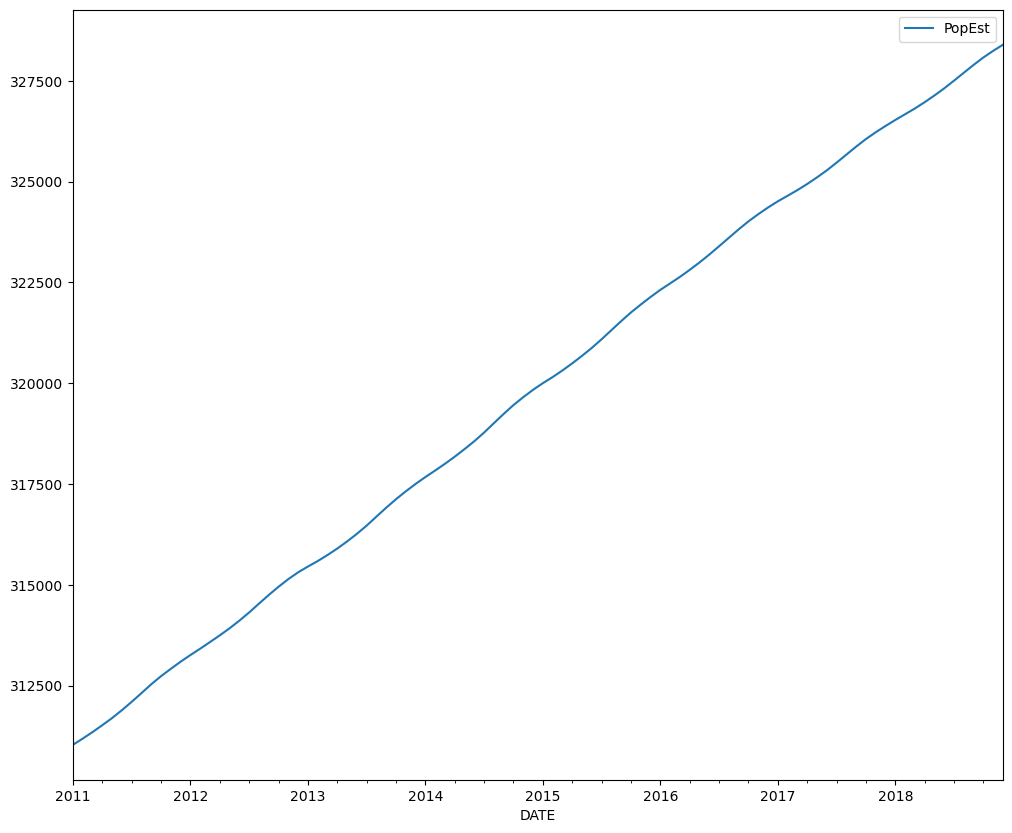

In [6]:
# Trend is pretty linear, autoregression should work well here
df.plot(figsize= (12, 10))

In [11]:
print(f'There are {len(df)} months in this data set.')
print(f'If we want to remove a year from the data, then there are {len(df) - 12} months in the data set.')

There are 96 months in this data set.
If we want to remove a year from the data, then there are 84 months in the data set.


In [12]:
# Perform Train Test Split

# Training set
train = df.iloc[:84]

# Test Set
test = df.iloc[84:]

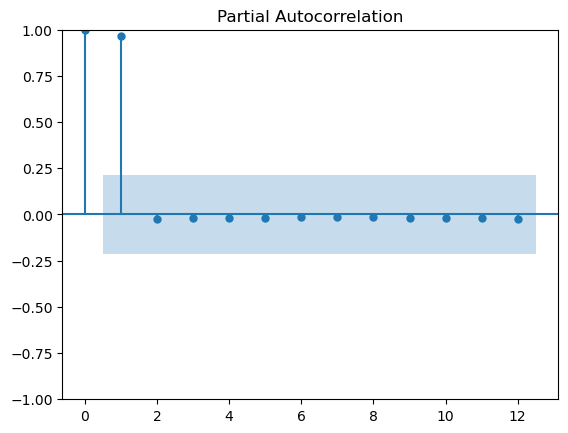

Selected lag order (p): 1
                            AutoReg Model Results                             
Dep. Variable:                 PopEst   No. Observations:                   84
Model:                     AutoReg(1)   Log Likelihood                -380.819
Method:               Conditional MLE   S.D. of innovations             23.789
Date:                Fri, 15 Dec 2023   AIC                            767.638
Time:                        15:47:10   BIC                            774.894
Sample:                    02-01-2011   HQIC                           770.553
                         - 12-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        284.9138    185.428      1.537      0.124     -78.518     648.346
PopEst.L1      0.9997      0.001   1718.076      0.000       0.999       1.001
                          

In [23]:
# Determine the lag order using the PACF plot
plot_pacf(train['PopEst'], lags=12)  # Adjust the number of lags as needed
plt.show()

# Or, you can calculate ACF and PACF values and select the lag order based on them
acf_values = acf(train['PopEst'])
pacf_values = pacf(train['PopEst'])

# Find the lag order based on significant PACF values
p = None
for lag in range(1, len(pacf_values)):
    if pacf_values[lag] > 0.2:  # Adjust the threshold as needed
        p = lag
        break

if p is not None:
    # Fit the AR model with the selected lag order (p)
    ARfit = AutoReg(train['PopEst'], lags=p).fit()
    print("Selected lag order (p):", p)
    print(ARfit.summary())
else:
    print("No significant lag order found.")


In [24]:
start = len(train)
end = len(train) + len(test) - 1
print(start)
print(end)

84
95


In [39]:
# Specify the lag order (p) as an argument
p = 1  # Adjust this to your desired lag order

# Fit the AR model
AR1fit = AutoReg(train['PopEst'], lags=p).fit()

In [40]:
predictions1 = AR1fit.predict(start = start, end = end)
predictions1 = predictions1.rename('AutoRegression (Order 1) Predictions')
predictions1

2018-01-01    326560.403377
2018-02-01    326742.749463
2018-03-01    326925.038278
2018-04-01    327107.269838
2018-05-01    327289.444162
2018-06-01    327471.561268
2018-07-01    327653.621173
2018-08-01    327835.623896
2018-09-01    328017.569455
2018-10-01    328199.457868
2018-11-01    328381.289152
2018-12-01    328563.063326
Freq: MS, Name: AutoRegression (Order 1) Predictions, dtype: float64

<Axes: xlabel='DATE'>

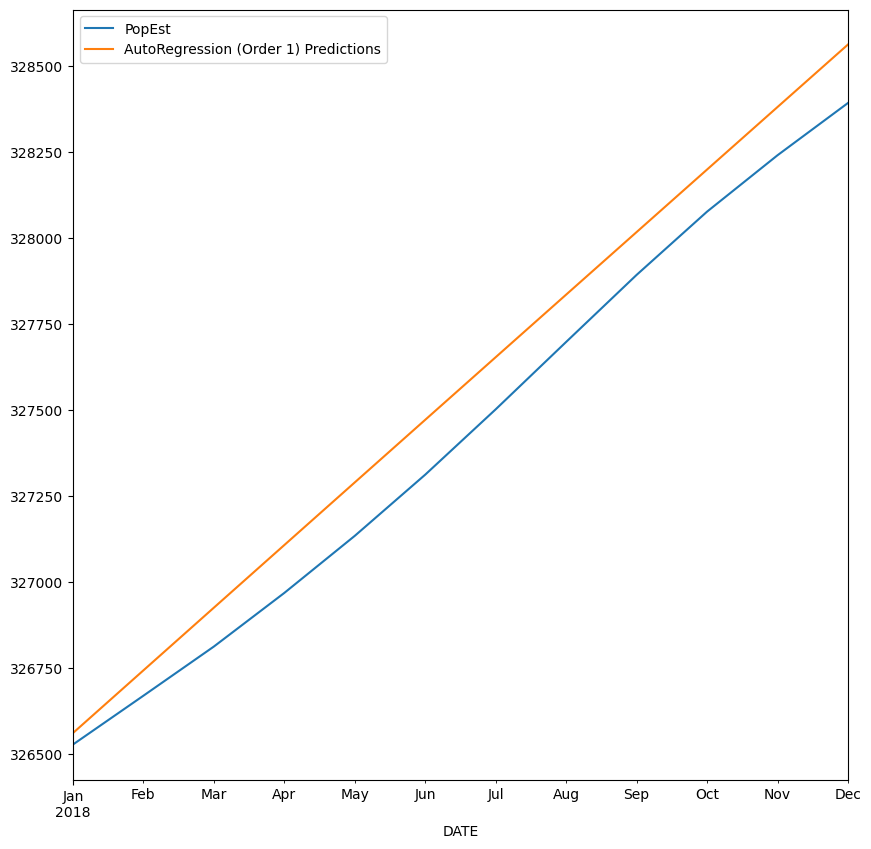

In [41]:
# Slight deviations of predictions though they should look similar
test.plot(figsize = (10, 10), legend = True)
predictions1.plot(legend = True)

In [42]:
AR1fit.params

const        284.913797
PopEst.L1      0.999686
dtype: float64

In [43]:
# Fit the AR model
p = 2
AR2fit = AutoReg(train['PopEst'], lags=p).fit()

In [46]:
predictions2 = AR2fit.predict(start = start, end = end)
predictions2 = predictions2.rename('AutoRegression (Order 2) Predictions')
predictions2

2018-01-01    326535.672503
2018-02-01    326694.718511
2018-03-01    326854.882251
2018-04-01    327015.944950
2018-05-01    327177.719501
2018-06-01    327340.045899
2018-07-01    327502.787334
2018-08-01    327665.826851
2018-09-01    327829.064485
2018-10-01    327992.414815
2018-11-01    328155.804866
2018-12-01    328319.172315
Freq: MS, Name: AutoRegression (Order 2) Predictions, dtype: float64

<Axes: xlabel='DATE'>

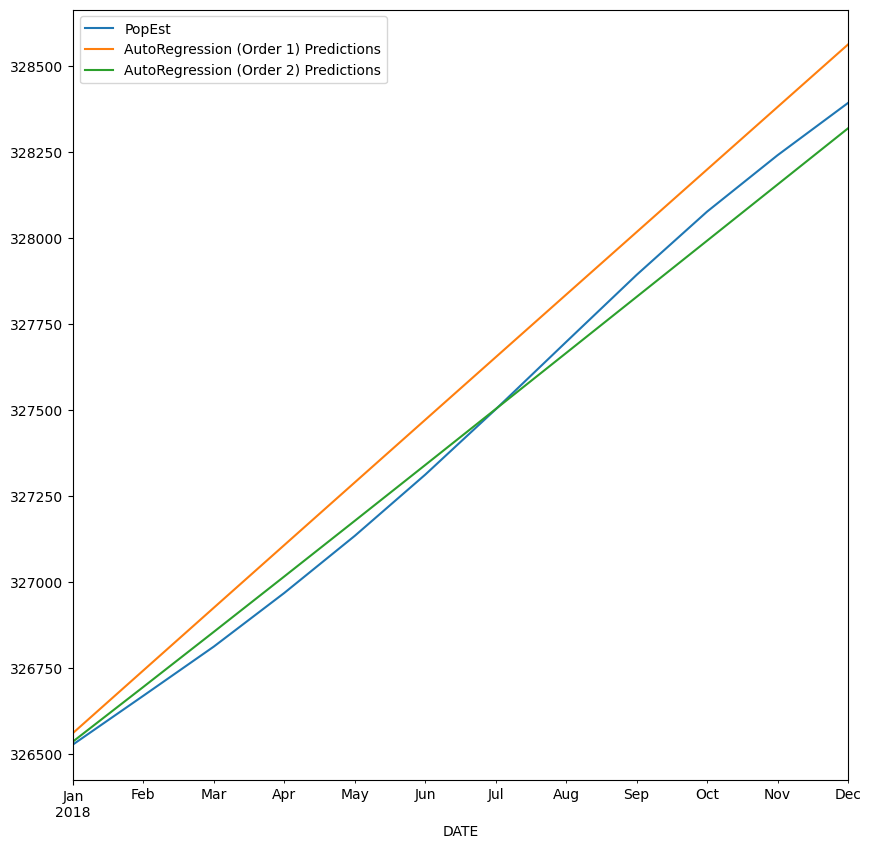

In [48]:
# Slight deviations of predictions though they should look similar
# Green Line is closer to the Population Estimate, which is as desired
test.plot(figsize = (10, 10), legend = True)
predictions1.plot(legend = True)
predictions2.plot(legend = True)

In [57]:
# How to get the best order value for greatest predictive strength?
# Fit the autoregressive model

model = AutoReg(train['PopEst'], lags=1)  # Specify the lag order as needed
ARfit = model.fit()

# Access information from the results object
print("Coefficient:", ARfit.params[0])  # Coefficient of the autoregressive term
print("Standard Error:", ARfit.bse[0])  # Standard error of the coefficient
print("AIC:", ARfit.aic)  # AIC value
print("Summary:", ARfit.summary())  # Model summary

# Make predictions
predictions = ARfit.predict(start = len(train), end = len(train) + 5)
print("\nPredictions:", predictions)

Coefficient: 284.9137967876741
Standard Error: 185.42789190438816
AIC: 767.6378091856313
Summary:                             AutoReg Model Results                             
Dep. Variable:                 PopEst   No. Observations:                   84
Model:                     AutoReg(1)   Log Likelihood                -380.819
Method:               Conditional MLE   S.D. of innovations             23.789
Date:                Fri, 15 Dec 2023   AIC                            767.638
Time:                        16:13:48   BIC                            774.894
Sample:                    02-01-2011   HQIC                           770.553
                         - 12-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        284.9138    185.428      1.537      0.124     -78.518     648.346
PopEst.L1      0.9997      0.001 

In [58]:
from sklearn.metrics import mean_squared_error

In [59]:
# Fit the AR model
p = 4
AR4fit = AutoReg(train['PopEst'], lags=p).fit()

# Fit the AR model
p = 6
AR6fit = AutoReg(train['PopEst'], lags=p).fit()

# Fit the AR model
p = 8
AR8fit = AutoReg(train['PopEst'], lags=p).fit()

In [61]:
predictions4 = AR4fit.predict(start = start, end = end)
predictions4 = predictions4.rename('AutoRegression (Order 4) Predictions')

predictions6 = AR2fit.predict(start = start, end = end)
predictions6 = predictions6.rename('AutoRegression (Order 6) Predictions')

predictions8 = AR8fit.predict(start = start, end = end)
predictions8 = predictions8.rename('AutoRegression (Order 8) Predictions')

In [62]:
labels = ['AR1', 'AR2', 'AR4', 'AR6', 'AR8']
preds = [predictions1, predictions2, predictions4, predictions6, predictions8]

In [65]:
for i in range(len(preds)):
    # Could also perform np.sqrt()
    error = mean_squared_error(test['PopEst'], preds[i])
    print(f'{labels[i]} MSE was :', {error})

AR1 MSE was : {17449.714238785422}
AR2 MSE was : {2713.2583179369417}
AR4 MSE was : {7511.754753860051}
AR6 MSE was : {2713.2583179369417}
AR8 MSE was : {186.97243772776312}


<Axes: xlabel='DATE'>

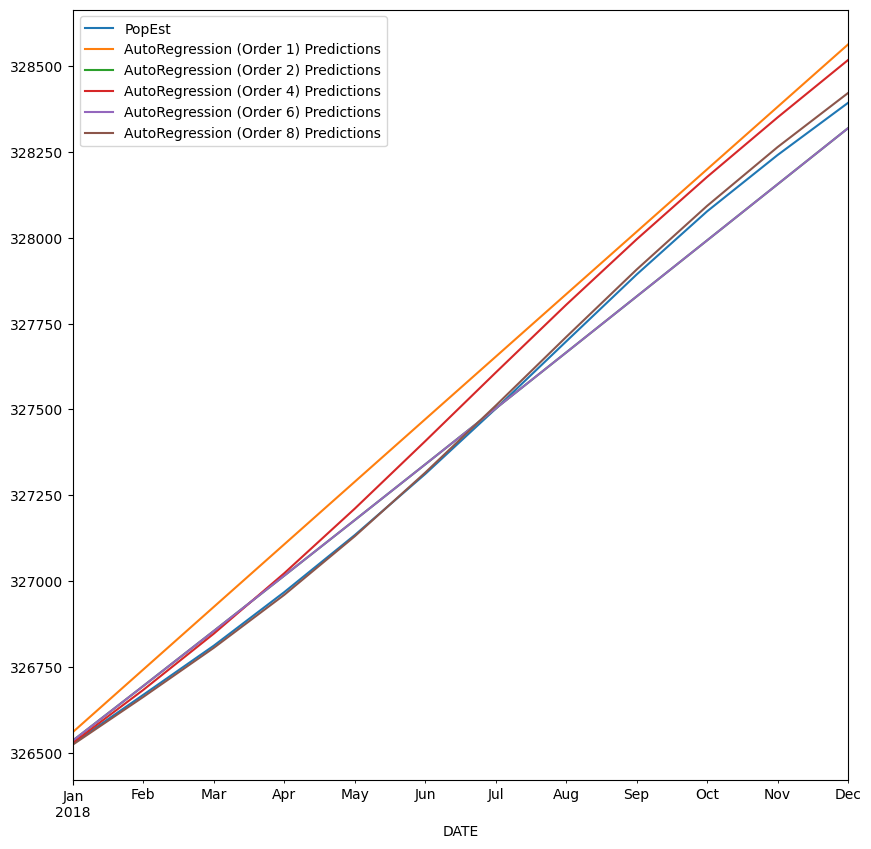

In [67]:
# Let's plot all the predictions now
# Some lines are really close to one another indicating performance of the model is high
test.plot(figsize = (10, 10), legend = True)
predictions1.plot(legend = True)
predictions2.plot(legend = True)
predictions4.plot(legend = True)
predictions6.plot(legend = True)
predictions8.plot(legend = True)

### Establishing forecasts on future data for US Population for 2024

In [71]:
p = 8
# model = AutoReg(df['PopEst'], lags = p)
ARfit = AutoReg(train['PopEst'], lags=p).fit()

forecasted_values = ARfit.predict(start = len(df), end = len(df) + 72).rename('2024 Forecast')

<Axes: xlabel='DATE'>

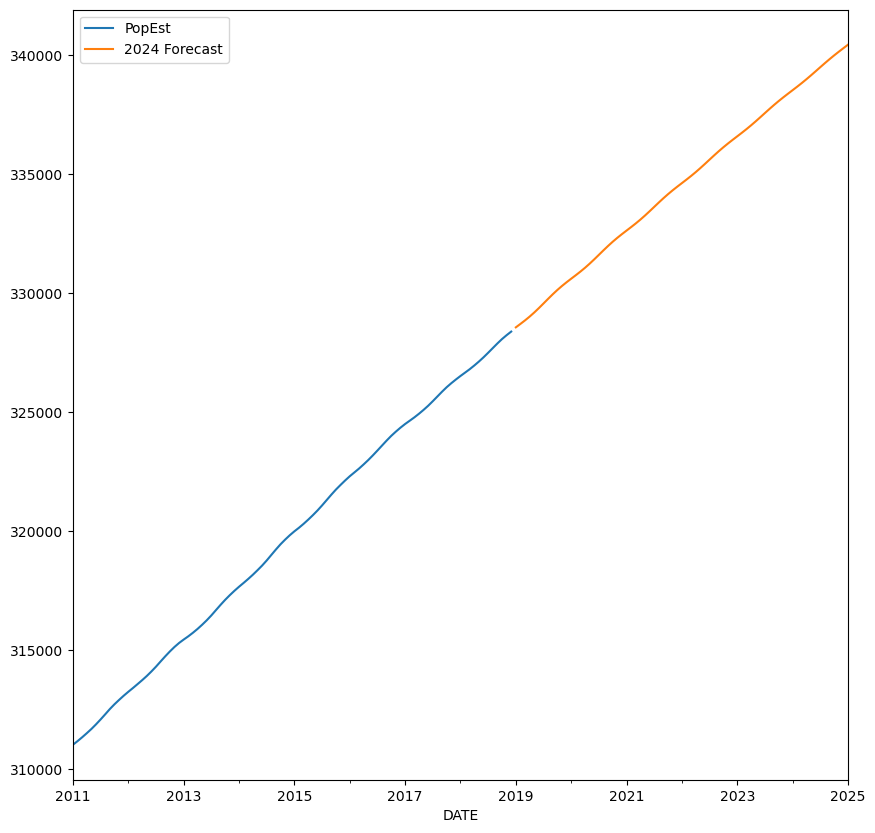

In [72]:
df['PopEst'].plot(figsize = (10, 10), legend = True)
forecasted_values.plot(legend = True)